In [12]:
import pandas as pd

In [13]:
df = pd.read_excel('combined_investing.com.xlsx', header=None, names=['Date_slv', 'Slv', 'Date_gld', 'Gld'])

In [14]:
df.head()

,Date_slv,Slv,Date_gld,Gld
0,Date_Slv,Slv,Date_Gld,Gld
1,2025-04-29 00:00:00,33.21,2025-04-29 00:00:00,3324.94
2,2025-04-28 00:00:00,33.042,2025-04-28 00:00:00,3348.09
3,2025-04-25 00:00:00,33.01,2025-04-25 00:00:00,3298.4
4,2025-04-24 00:00:00,33.503,2025-04-24 00:00:00,3348.6


In [15]:
# Convert date columns to datetime
df['Date_slv'] = pd.to_datetime(df['Date_slv'], errors='coerce')
df['Date_gld'] = pd.to_datetime(df['Date_gld'], errors='coerce')

# Build separate series for each
silver = df[['Date_slv', 'Slv']].dropna().rename(columns={'Date_slv': 'Date'})
gold = df[['Date_gld', 'Gld']].dropna().rename(columns={'Date_gld': 'Date'})

# Merge on dates using outer join to get full coverage
merged = pd.merge(silver, gold, on='Date', how='outer')

# Sort by date and filter to 1975 onwards
merged = merged.sort_values('Date')
merged = merged[merged['Date'] >= pd.Timestamp('1975-01-01')]

# Forward-fill missing values
merged.fillna(method='ffill', inplace=True)

# (Optional) Also backfill if some early rows are still NaN
merged.fillna(method='bfill', inplace=True)

# Reset index if needed
merged.reset_index(drop=True, inplace=True)

# Resulting DataFrame: merged
print(merged.head())


        Date    Slv    Gld
0 1975-01-02  4.378  174.7
1 1975-01-03  4.290  174.7
2 1975-01-06  4.290  174.4
3 1975-01-07  4.195  173.4
4 1975-01-08  4.180  177.4


In [16]:
merged['gold/silver'] = merged['Gld']/merged['Slv']
merged['gold/silver'].describe()

count    12774.000000
mean        62.911866
std         17.542273
min         16.523236
25%         50.972701
50%         65.251382
75%         75.507196
max        125.543663
Name: gold/silver, dtype: float64

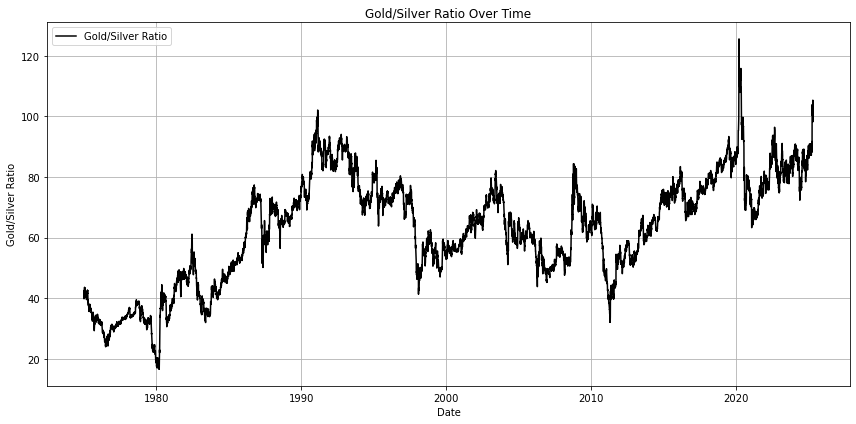

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(merged['Date'], merged['gold/silver'], label='Gold/Silver Ratio', color='black')
plt.title('Gold/Silver Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Gold/Silver Ratio')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


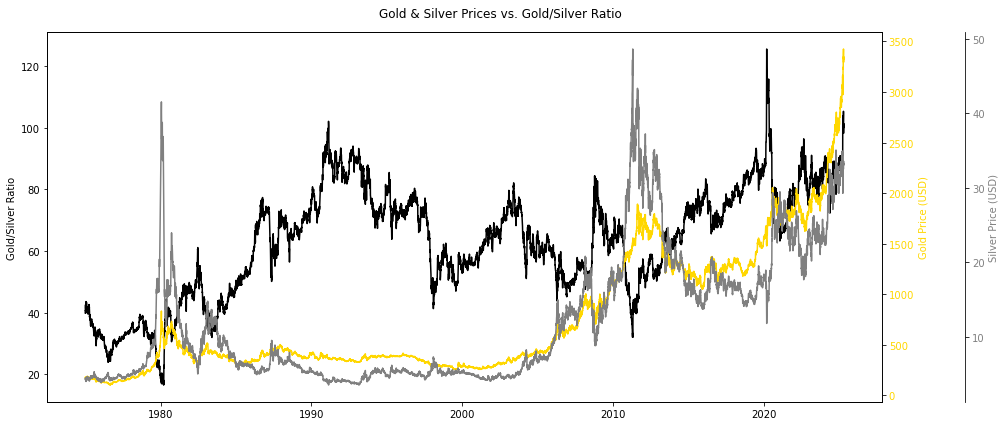

In [18]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(14, 6))

# Gold/Silver ratio (primary y-axis, black)
ax1.plot(merged['Date'], merged['gold/silver'], color='black', label='Gold/Silver Ratio')
ax1.set_ylabel('Gold/Silver Ratio', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Gold price (secondary y-axis, gold)
ax2 = ax1.twinx()
ax2.plot(merged['Date'], merged['Gld'], color='gold', label='Gold Price')
ax2.set_ylabel('Gold Price (USD)', color='gold')
ax2.tick_params(axis='y', labelcolor='gold')

# Silver price (tertiary y-axis, gray)
ax3 = ax1.twinx()
ax3.spines["right"].set_position(("axes", 1.1))  # Offset third y-axis
ax3.plot(merged['Date'], merged['Slv'], color='gray', label='Silver Price')
ax3.set_ylabel('Silver Price (USD)', color='gray')
ax3.tick_params(axis='y', labelcolor='gray')

# Title and layout
fig.suptitle('Gold & Silver Prices vs. Gold/Silver Ratio')
fig.tight_layout()
plt.show()


In [22]:
import numpy as np

# Create column for yesterday's ratio
merged['prev_ratio'] = merged['gold/silver'].shift(1)

# Identify crossing events
cross_80 = (merged['prev_ratio'] < 80) & (merged['gold/silver'] >= 80)
cross_100 = (merged['prev_ratio'] < 100) & (merged['gold/silver'] >= 100)

# Helper: calculate forward returns
def compute_returns(df, event_mask, days_list):
    event_dates = df.loc[event_mask, 'Date'].reset_index(drop=True)
    results = []

    for event_date in event_dates:
        row = {'Event Date': event_date}
        start = df[df['Date'] == event_date].iloc[0]
        
        for d in days_list:
            # Try to find data d days after event_date
            future = df[df['Date'] >= event_date + pd.Timedelta(days=d)]
            if not future.empty:
                end = future.iloc[0]
                row[f'Gold_{d}d'] = (end['Gld'] - start['Gld']) / start['Gld'] * 100
                row[f'Silver_{d}d'] = (end['Slv'] - start['Slv']) / start['Slv'] * 100
                row[f'Ratio_{d}d'] = (end['gold/silver'] - start['gold/silver']) / start['gold/silver'] * 100
            else:
                # Not enough data — use last available value
                last = df.iloc[-1]
                row[f'Gold_{d}d'] = (last['Gld'] - start['Gld']) / start['Gld'] * 100
                row[f'Silver_{d}d'] = (last['Slv'] - start['Slv']) / start['Slv'] * 100
                row[f'Ratio_{d}d'] = (last['gold/silver'] - start['gold/silver']) / start['gold/silver'] * 100
        
        results.append(row)
    
    return pd.DataFrame(results)

# Days to look ahead
days = [30, 90, 180, 360]

returns_80 = compute_returns(merged, cross_80, days)
returns_100 = compute_returns(merged, cross_100, days)


In [23]:
returns_80.tail()

,Event Date,Gold_30d,Silver_30d,Ratio_30d,Gold_90d,Silver_90d,Ratio_90d,Gold_180d,Silver_180d,Ratio_180d,Gold_360d,Silver_360d,Ratio_360d
55,2023-07-28,-2.619156,-1.019496,-1.616136,0.903507,-6.953696,8.444402,2.329831,-7.030869,10.068611,21.552205,19.094232,2.063889
56,2023-08-02,0.123330,1.879872,-1.724130,2.482014,-3.818098,6.550206,4.080164,-3.084490,7.392681,22.189106,16.151890,5.197690
57,2023-09-04,-6.478541,-12.997326,7.492625,4.112465,1.979017,2.092047,8.895831,-1.291915,10.321086,29.913961,22.719605,5.862434
58,2024-07-17,1.776495,-4.585706,6.667975,8.419041,4.539619,3.710959,8.890605,-0.223854,9.134908,35.165657,9.326135,23.635265
59,2024-10-23,-0.180339,-6.926919,7.248690,2.521070,-6.923963,10.147654,26.064554,-3.894914,31.173655,22.370910,-1.858802,24.688625


In [24]:
returns_100.head()

,Event Date,Gold_30d,Silver_30d,Ratio_30d,Gold_90d,Silver_90d,Ratio_90d,Gold_180d,Silver_180d,Ratio_180d,Gold_360d,Silver_360d,Ratio_360d
0,1991-02-21,-1.290854,8.598901,-9.106681,-2.004944,11.483516,-12.099062,-0.769020,8.379121,-8.440870,-2.581708,11.483516,-12.616417
1,2020-03-13,15.368893,7.317241,7.502664,14.373310,23.931034,-7.712131,28.357619,86.489655,-31.171722,10.634931,74.268966,-36.514840
2,2025-04-04,9.538776,13.616148,-3.588726,9.538776,13.616148,-3.588726,9.538776,13.616148,-3.588726,9.538776,13.616148,-3.588726
3,2025-04-28,-0.691439,0.508444,-1.193813,-0.691439,0.508444,-1.193813,-0.691439,0.508444,-1.193813,-0.691439,0.508444,-1.193813


In [32]:
# Step 1: Make a copy of returns_80 and returns_100
returns_80_rounded = returns_80.copy()
returns_100_rounded = returns_100.copy()
returns_80_rounded.set_index('Event Date', inplace=True)
returns_100_rounded.set_index('Event Date', inplace=True)

# Step 2: Round the returns to 2 decimal places and add '%' sign
for df in [returns_80_rounded, returns_100_rounded]:
    for col in df.columns:
        if col != 'Event Date':  # Exclude 'Event Date' column from rounding and formatting
            df[col] = df[col].round(2).astype(str) + '%'  # Round and format with '%'

# Step 3: Rearrange the columns in the desired order
column_order = [
    'Gold_30d', 'Gold_90d', 'Gold_180d', 'Gold_360d',  # Gold returns first
    'Silver_30d', 'Silver_90d', 'Silver_180d', 'Silver_360d',  # Silver returns next
    'Ratio_30d', 'Ratio_90d', 'Ratio_180d', 'Ratio_360d'  # Ratio returns last
]

# Reorder the columns for both DataFrames (returns_80_rounded and returns_100_rounded)
returns_80_rounded = returns_80_rounded[column_order]
returns_100_rounded = returns_100_rounded[column_order]

# Step 4: Display the results (or export to a file)
# Display the rounded results (returns_100_rounded as an example)
returns_100_rounded


,Gold_30d,Gold_90d,Gold_180d,Gold_360d,Silver_30d,Silver_90d,Silver_180d,Silver_360d,Ratio_30d,Ratio_90d,Ratio_180d,Ratio_360d
Event Date,,,,,,,,,,,,
1991-02-21,-1.29%,-2.0%,-0.77%,-2.58%,8.6%,11.48%,8.38%,11.48%,-9.11%,-12.1%,-8.44%,-12.62%
2020-03-13,15.37%,14.37%,28.36%,10.63%,7.32%,23.93%,86.49%,74.27%,7.5%,-7.71%,-31.17%,-36.51%
2025-04-04,9.54%,9.54%,9.54%,9.54%,13.62%,13.62%,13.62%,13.62%,-3.59%,-3.59%,-3.59%,-3.59%
2025-04-28,-0.69%,-0.69%,-0.69%,-0.69%,0.51%,0.51%,0.51%,0.51%,-1.19%,-1.19%,-1.19%,-1.19%


In [33]:
returns_80_rounded.head()

,Gold_30d,Gold_90d,Gold_180d,Gold_360d,Silver_30d,Silver_90d,Silver_180d,Silver_360d,Ratio_30d,Ratio_90d,Ratio_180d,Ratio_360d
Event Date,,,,,,,,,,,,
1990-01-30,-3.51%,-12.38%,-11.11%,-11.28%,-0.29%,-4.39%,-7.72%,-27.23%,-3.24%,-8.37%,-3.67%,21.92%
1990-08-06,-0.2%,-3.22%,-5.64%,-5.97%,-1.69%,-14.09%,-21.61%,-17.62%,1.51%,12.64%,20.37%,14.15%
1990-08-15,-4.94%,-5.91%,-10.26%,-11.62%,-4.93%,-17.22%,-27.34%,-22.07%,-0.0%,13.66%,23.5%,13.41%
1990-09-04,1.64%,-3.07%,-5.38%,-9.63%,-1.97%,-12.33%,-19.17%,-19.79%,3.68%,10.56%,17.06%,12.67%
1990-09-14,-3.2%,-3.81%,-5.86%,-9.16%,-13.62%,-15.75%,-14.31%,-15.24%,12.07%,14.18%,9.86%,7.17%


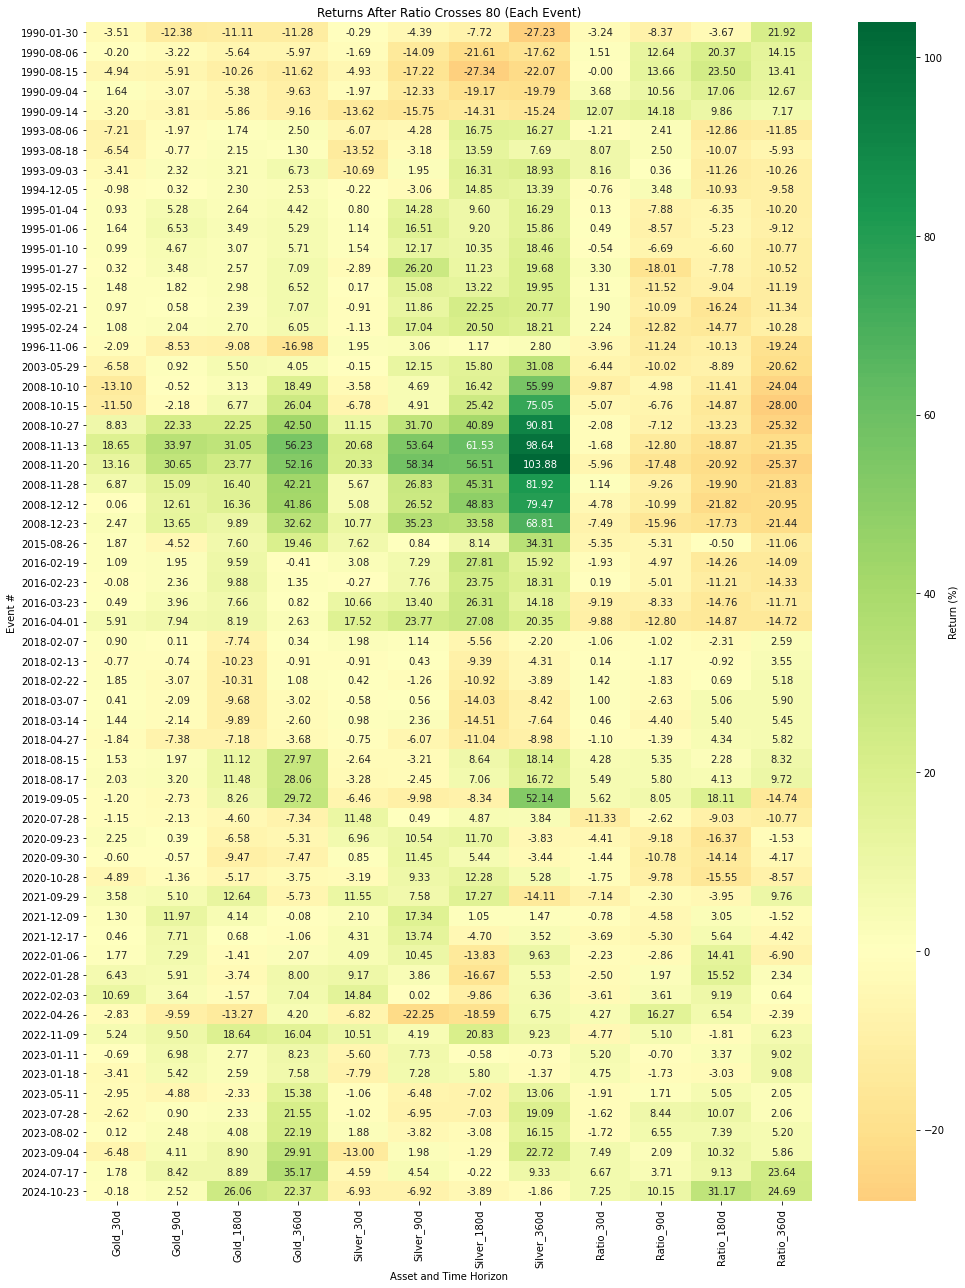

In [35]:
import seaborn as sns

# Remove '%' and convert to numeric
returns_80_clean = returns_80_rounded.copy()
returns_80_clean.index = returns_80_clean.index.strftime('%Y-%m-%d')

for col in returns_80_clean.columns:
    if col != 'Event Date':  # Exclude 'Event Date' column
        returns_80_clean[col] = returns_80_clean[col].str.replace('%', '').astype(float)

# Now, create the heatmap with the cleaned data
plt.figure(figsize=(14, len(returns_80_clean) * 0.3))

# Plot the heatmap for returns_80_clean (after removing '%' and converting to float)
sns.heatmap(
    returns_80_clean, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
    cbar_kws={'label': 'Return (%)'}
)

# Add labels and title
plt.title('Returns After Ratio Crosses 80 (Each Event)')
plt.xlabel('Asset and Time Horizon')
plt.ylabel('Event #')

# Adjust layout for better visualization
plt.tight_layout()

# Display the heatmap
plt.show()


<ipython-input-37-a53d881cecb6>:25: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


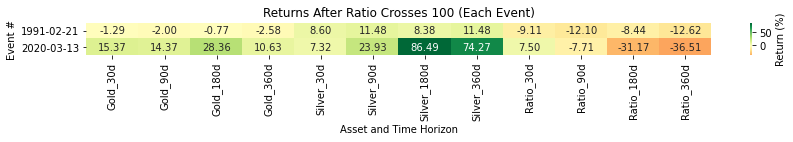

In [37]:
# Remove '%' and convert to numeric for returns_100_rounded
returns_100_clean = returns_100_rounded.copy()
returns_100_clean = returns_100_clean.iloc[:-2]
returns_100_clean.index = returns_100_clean.index.strftime('%Y-%m-%d')

for col in returns_100_clean.columns:
    if col != 'Event Date':  # Exclude 'Event Date' column
        returns_100_clean[col] = returns_100_clean[col].str.replace('%', '').astype(float)

# Now, create the heatmap for returns_100_clean (after removing '%' and converting to float)
plt.figure(figsize=(14, len(returns_100_clean) * 0.3))

# Plot the heatmap for returns_100_clean
sns.heatmap(
    returns_100_clean, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
    cbar_kws={'label': 'Return (%)'}
)

# Add labels and title
plt.title('Returns After Ratio Crosses 100 (Each Event)')
plt.xlabel('Asset and Time Horizon')
plt.ylabel('Event #')

# Adjust layout for better visualization
plt.tight_layout()

# Display the heatmap
plt.show()


In [38]:
# Compute mean returns from cleaned data
combined_returns = pd.concat([
    returns_80_clean.mean().rename('Crosses 80'),
    returns_100_clean.mean().rename('Crosses 100')
], axis=1)

# Optionally round and format as strings with '%' sign
combined_returns = combined_returns.applymap(lambda x: f"{x:.2f}%")

# Extract specific horizons
returns_30d = combined_returns.loc[['Gold_30d', 'Silver_30d', 'Ratio_30d']].T
returns_90d = combined_returns.loc[['Gold_90d', 'Silver_90d', 'Ratio_90d']].T
returns_180d = combined_returns.loc[['Gold_180d', 'Silver_180d', 'Ratio_180d']].T
returns_360d = combined_returns.loc[['Gold_360d', 'Silver_360d', 'Ratio_360d']].T

# Display results
print("\n--- Mean Returns for 30 Days ---")
display(returns_30d)

print("\n--- Mean Returns for 90 Days ---")
display(returns_90d)

print("\n--- Mean Returns for 180 Days ---")
display(returns_180d)

print("\n--- Mean Returns for 360 Days ---")
display(returns_360d)



--- Mean Returns for 30 Days ---


,Gold_30d,Silver_30d,Ratio_30d
Crosses 80,0.29%,1.10%,-0.54%
Crosses 100,7.04%,7.96%,-0.80%



--- Mean Returns for 90 Days ---


,Gold_90d,Silver_90d,Ratio_90d
Crosses 80,2.94%,6.61%,-2.51%
Crosses 100,6.18%,17.70%,-9.90%



--- Mean Returns for 180 Days ---


,Gold_180d,Silver_180d,Ratio_180d
Crosses 80,2.99%,7.68%,-2.56%
Crosses 100,13.79%,47.43%,-19.80%



--- Mean Returns for 360 Days ---


,Gold_360d,Silver_360d,Ratio_360d
Crosses 80,9.61%,17.22%,-4.06%
Crosses 100,4.03%,42.88%,-24.56%
